pre denG
1.0687908514190354
1.0
1.2231486188689074
0.8785614213218003
0.9136466101768337
2.3424265575367755
0.9115029184849518
0.9444717225473629
2.2949195970097382
1.0525186659158323
1.0
2.636069089641275
1.0726992794741714
1.0909851728523643
4.337852331806456
1.0
1.0
6.444115359417405
1.0116568311937526
0.8562425585858313
7.3120147491969885
1.0
0.8883503497191553
8.471743344789251
1.0
1.0
9.471743344789251
1.0767686439811812
1.0658929600232112
10.614404948793643
1.0
1.0
14.305122155796852
1.032404609487113
1.0025161872570998
15.340042952541065
1.0
1.0
17.913180121278288
0.891123487001063
0.7843688591226634
18.588672467402013
1.0
1.0
13.806306056179691
1.0509721613774907
1.0
14.857278217557182
1.0
0.9414573035886264
18.21766153187819
1.0
0.9476566536649136
19.165318185543104
1.0
1.030461497420299
20.1957796829634
1.013822650113308
1.0
21.20960233307671
1.0
0.8010696069176783
22.910895317077575
0.8773575160785196
1.0
23.788252833156093
1.0
1.0
16.582585770681376
0.9934806775114913
1.17

1.0304320189314737
5620237.427609208
1.0120726962054887
67523.23897930582
0.9072138064947691
4874468.257283283
1.0
70140.0021781086
0.7519598081666834
5122421.976500865
0.952897007652058
81730.51892091907
0.9651850000263724
5192562.183535789
1.0
78967.45972013914
0.890660092565779
4552392.32686215
1.1373464200976948
91027.31848717526
1.0
4631360.314588802
1.0
42094.35422997706
1.1508521883089184
6846363.850266161
1.1127858773595176
59819.78808574726
1.0520740569159792
6888458.968134205
1.0
61397.89796347255
0.9397741872432103
9476055.775952598
1.0
76341.47862804397
1.0
9537454.113690257
1.251627319697246
88868.16949505461
0.9986069115974832
9613796.34394562
0.9251099131597001
55666.94340800856
1.0
18255705.0560858
0.878247270784063
70851.35728064393
0.891625153733691
14402751.265311848
1.0256675908478903
71115.97094411377
1.0
9616106.675018102
1.0540099650818482
123109.34962053839
1.0
10445930.579369755
1.0894711207659242
124629.10998954739
0.8501165634291669
12343202.358396776
1.10558

2866773286.3464246
0.8735905118754893
771556771.2351524
1.1712436223222285
3507560026.888596
0.8419046538252329
1138468951.6554813
1.0585416141081927
2793108990.774158
1.1273112966877539
1230930842.4950569
1.0
2263418222.6648235
1.0
1568690679.4987683
1.0
4942233378.622662
1.0
953043434.4989475
1.0
6510924058.621429
1.0
870612553.4770644
1.0
7463967493.620377
1.2186727672986135
1143393129.365656
1.0163995870333682
8334580047.816113
0.9637263448982964
1387748196.1829658
1.015094031080044
16602128303.260551
1.0
2082805802.0312498
0.939371122022657
16079542142.967852
1.0
1537366175.6464064
0.8590854404016739
18162347945.438473
0.9711140449915009
1605942385.2228668
0.9296184878081454
19699714121.41508
0.9747460253302842
1388671201.2007816
0.847113560239177
19494908612.480415
1.0082883955086064
1248975037.6023138
1.0
19328037186.072605
0.8606006755065931
1345869101.081492
1.0
21091490649.71665
0.8355192502169714
1398775900.0006552
1.0
13926114626.128635
1.0
1508794796.4797034
1.0
8592138708

57602326094.53394
1.0
137021042345.63747
1.0284045207171009
69438620083.66414
1.0830186289517403
277108442957.07263
1.1021649446035586
82408618033.04317
1.0
376636772719.1524
1.0214175240938999
98856444729.15816
1.0336396734199533
609323165532.3646
1.0196559591036385
102872160598.03816
0.9998388430141885
754331670476.0525
1.0356706216801699
109983711471.18481
0.9182844259279218
908413694351.1444
1.0
105684546109.78723
1.0
1129969615544.3127
0.9017445689777189
126526184181.02081
0.9122723661864792
1235654161654.502
1.0229262990973653
124310308354.12386
1.0298791324923449
986956826341.6309
1.0
184829178850.45682
0.8403636704308728
1188867060590.5664
0.9272746414374577
222395279555.62515
0.9334318806343221
1373696239441.2908
1.0220289215973846
285161850069.4813
1.0
1264745920095.749
1.017413834638248
336702842327.98157
1.1336773713517048
1653840418407.727
1.0
396578414634.79694
1.0
2095739465477.5874
0.9871118782970704
476859860180.1339
0.8601342232759632
2492317880112.8716
0.935891999210

0.8404941821566725
10900804628293.896
0.760005480474968
1354697715711.1218
0.6705882352941176
9133800753103.262
0.914127143203252
3982315941702.506
0.4684553002598625
4145171858690.59
0.8506444296631303
3817562841327.8086
0.604783118585327
6153562600640.495
0.8
4688579004906.827
0.6313725490196078
5948249573403.526
0.8513779805225749
5886314482046.098
0.636563730781256
5105677717589.222
0.5284661753046966
10723122844499.451
0.6392156862745098
6576629305412.102
0.5126139445174539
14250439924271.742
0.6287205050440284
520494556272.46643
0.6392156862745098
11177406685886.895
0.6624605162358115
191020201936.79318
0.6313725490196078
9304164320231.373
0.6431372549019608
2023326480166.2102
0.6352941176470588
4579518977322.575
0.6038525070481567
1879117927934.0781
0.6072399080605672
4980850426510.945
0.7582250980290639
1110259797416.1099
0.6392156862745098
5313935152825.715
0.6890829840416215
793310482623.5532
0.7396302781091803
7434525852643.57
0.7023009016384458
1086953536933.1833
0.74834023

0.9716246496696211
43764559985591.9
0.6317179114695185
67862318681346.266
0.7677086599411732
59148848780140.54
0.43069053197106283
102304278409859.25
0.6397756584962595
76699037053136.34
0.49538781327536663
66364422063354.875
0.48147726586332573
68923928622376.3
0.5067960938394191
25586917962573.094
0.8397806186855068
37321247057928.805
0.4723337070238943
-1685747514077.7058
0.6969201593540651
140526101127.00992
0.6650263586810694
20336550849541.08
0.6477419267481783
-645759329887.403
0.7093441215572746
5620450972447.841
0.6386706928630357
3071799994420.59
0.615686274509804
952142452143.8591
0.6196078431372549
2662257326343.822
0.611764705882353
712760181055.582
0.5070837610335783
5911217507.065658
0.41256419733050353
500244809478.5003
0.6908555005874866
98980742129.27533
0.6881127290253659
3636285826.5555573
0.6235294117647059
182726529082.9019
0.6363138944935299
27060843450.051895
0.5669861109382631
240685156929.338
0.6235294117647059
32317418080.540253
0.612770159660187
97409984176.

6245555792692.225
0.9800924951840603
10484648304279.941
1.0
4934045210861.401
0.8781501857271274
12331327010350.104
0.8766707930736477
6335456384027.628
0.6500939798408963
17265372221211.76
0.6519657009971375
17718891940099.2
0.5450980392156862
15586755790365.686
0.5764705882352941
43981532209240.26
0.5961513951621805
6599609004108.269
0.4173397579779586
75133640994990.9
0.7515242800369881
4459541446768.993
0.5392585586545693
17093444238653.533
0.5297408270307187
-5491516563519.176
0.5803921568627451
9057275327217.91
0.5897637345250069
491237538860.47473
0.4318758486682137
1785553360804.5415
0.5151506880470029
891047690448.1392
0.6733616894409522
-470341641786.2348
0.5843137254901961
-157497499460.7908
0.659205654115162
-321759955738.01294
0.5525931043393925
-146581755096.37518
0.4878900894422046
-36452781934.92932
0.5417420841725338
-98304238851.92653
0.5270747478886346
-41386522183.91625
0.6322255284969541
1592371252.9420037
0.6770141682829021
38314041401.35885
0.6146839722054747
-11

95958648980.88472
0.9118284602614339
539843858155.8139
0.8834813756555941
276220469036.6505
1.1017299195820407
1236489712901.646
1.141918167032105
612891910342.8972
0.9030089964384158
2181712951324.1016
1.0
2452072368730.772
1.0481552075569938
7104402345979.425
1.0
3372661252740.17
1.0020546569672593
9606128610107.418
0.8509803921568627
12039230144041.11
0.9889283186012955
12593959638970.154
0.5529411764705883
21778962872421.33
0.5811213375348764
43498386924532.04
0.4885701536253069
33239651383068.1
0.5294117647058824
21285531489343.6
0.6239001316721754
7235067935810.453
0.5529411764705883
8546240584772.788
0.5529411764705883
888184757185.203
0.5636916906000525
228578087380.7418
0.5025214569669403
552354590955.221
0.5386272850575801
86600582027.22447
0.5529411764705883
56074834657.34801
0.4419292150328624
194607767990.59174
0.5273102364058586
5936926596.399791
0.670855384503254
-240787654091.6023
0.4551541820135144
-10293227752.765102
0.5701367244963543
-24992150997.39136
0.57775360781

1.0
46679375.93584475
0.9828452555003427
6841822.106842489
1.0
122210471.37886982
1.0
53521198.52553249
1.0218091213791372
662485442.7852064
1.0733071364325393
175731670.42621145
0.9952751650853164
3964700003.723464
1.0
893856825.5227886
0.8155198791635758
11098387028.930056
1.0
4789906118.215631
1.0
36968527628.00016
1.0711695420461043
8176520288.465478
0.9714694216455305
114260839221.26561
0.9575183166465532
45145047917.00827
1.0
441117973486.8095
0.968043616525075
146021571519.153
1.0396468636769578
1077889394998.9158
1.0373814614492738
587139545006.4702
0.9882352941176471
5606245692927.253
0.5750945774701526
1868302896945.8027
0.717909587690404
13608402130575.74
0.47759867066540335
7212810071777.665
0.5176470588235295
14681951988898.947
0.5231415239892313
6514515149373.275
0.5450980392156862
395878992081.0959
0.6287763729912864
387257254291.4091
0.39484627413712403
135146812202.3454
0.5884320535208161
38503446054.32197
0.45524103969956103
-197263320.83986947
0.5525287891169132
-144

-0.02901290539591965
0.5104464690984956
0.15712624340359677
0.46879948159130863
-0.1975517170336788
0.6076859551789255
-0.01725819760545832
0.5
0.0
0.6226532452473904
-0.1389916718068309
0.5
0.17460601913205998
0.48185440718135414
-0.028872479507011075
0.5
1.0
0.3450342832242189
1.1471611946840603
4718.421976191513
0.9332831129745838
0.5303013717360716
1.117827509217407
514864.18192434986
1.0
7007.259329638137
1.00006236571829
7065554.163161568
0.9375702561883471
720834.9959524095
1.0
65299340.17013505
1.0229544619224167
7787846.468500991
0.8068485466519766
200433282.46981198
0.9727704729892269
73087186.96843904
1.0
2326983602.571592
0.8120053412885807
135436562.383908
0.8657813245730486
8019941097.716205
1.0345766535171093
2462420165.1332865
0.8736378602193314
22067601989.14825
0.9804769025738029
6639247529.200324
0.9088713380918878
94873440274.99857
0.9989797804451811
18741219669.377514
0.9269710641509121
159661995714.85693
0.7019607843137254
84441014810.65306
0.6787556237532468
5910

10263.996964088146
0.01468815926457838
25570.186169695964
0.08522976769172046
169131.3179633784
0.0
555.4340672262963
0.08683708484310983
-2775.2688108995335
0.1707774032496595
0.5
0.0
0.5
0.0
0.4291211963637573
-0.12318846549611545
0.6124475603282659
0.0
0.5
0.040560897907120835
0.5
0.037639846990235294
0.5
0.04775687031089708
0.5
0.05273401295169086
0.5074779489847262
0.024279677202374218
0.5313086118993695
-0.05722527887253982
0.48852591385899014
-0.056815911363385346
0.54689672945689
-0.04696251831679938
0.45324789407236765
-0.052264863016559665
0.4318658832700433
0.18172223664298626
0.5
0.9715894210586713
0.449375096083644
1.0091044942883374
0.39730955802869716
1.0556994772808095
0.3924130635358618
0.976202454154197
3.105067234123683
1.0
1.3442021930523338
1.0
3912.226737516903
1.0
4.636663796550422
0.8758787968939262
702638.2952831669
1.1731233335658617
3917.2392801103474
1.0144301086004273
11000512.702125335
1.1455360955402258
465231.08139738353
1.0531441479860313
96672272.88072

7.290082574493786e+30
0.9963927761886106
3.0151957538338925e+30
0.9953105417061296
9.728511292379112e+30
1.079659801612087
4.8291060156098524e+30
1.0
1.260613047955941e+31
1.0136816708059169
6.62008149025106e+30
1.237483470506968
2.1823175938243115e+31
0.8557000927192675
6.912887782150814e+30
1.024102315514025
2.9621359762392244e+31
66.57333399544683
0.9338448560350833
1.1048197797409633
2710.7051068580604
0.8342634782338328
84.63668281176183
0.9498675631258711
14662.191477898135
1.0
3736.000508808836
1.075813151480778
285626.79124633205
1.0757390950187142
15724.197108857716
0.12916657853008676
4320.996610913899
-0.02258815485021892
373353.718007891
0.0
894.4790397572083
-0.005031780223091226
-36180.00326251476
0.0
0.5
0.17786049728713157
0.5
-0.12768492341266666
0.5
0.0564100354089357
0.5
-0.07302569926244001
0.6205926397094352
0.0
0.3370448425406288
-0.15557535146072302
0.3454636624084545
0.1518264983368156
0.39974313648857707
0.0
0.5603819103213713
0.0
0.2750138392989583
0.212013788

1.0
1.3674068463752582e+30
1.0
2.3109746386213687e+30
1.0
2.343355381180616e+30
1.0
3.678381484996627e+30
1.0
4.4338710623753795e+30
1.1452319222570653
6.021736866177243e+30
1.0
7.382424521344248e+30
0.7599081643976446
1.0455607928552622e+31
1.0552944218903988
1.2650715320573254e+31
1.0
1.783803244989687e+31
1.0
3.415918465605278e+31
1.1640058948101237
3.5732757868706885e+31
0.9048739542793561
3.97064029050032e+31
1.0
6.989194252475967e+31
1.1037670113474536
3.8809801245695413e+31
0.9137912392282377
8.030487686541088e+31
0.8583725382891072
5.603415879824144e+31
1.0
1.5876035724035563e+32
1.0
1.0270309997746354e+32
1.0837352288995301
1.321489517188208e+32
1.0
2.16150839916025e+32
0.9980901435645704
2.348520516962843e+32
1.0802735277500168
3.801326011884619e+32
1.0863606883233825
4.510028916123093e+32
106.06253569945326
1.0333634925239001
1.0533021534484834
1723.048389723459
1.0
107.74861900664268
1.0
13698.584225741519
1.0
2134.4563043991784
0.9602593496042636
470090.450854027
0.8913662

0.4957575628810489
9.45367717693993e+22
0.8449787288195495
1.472786443325661e+28
0.6840730333614763
1.5016474694245568e+24
1.0
4.926805036035162e+28
1.0
8.587211226507202e+27
1.041634133178659
2.8724496511722155e+29
1.03036048950461
5.785526158685883e+28
1.0416715242595564
4.0073137775897646e+29
1.0034403575184458
3.894004672873983e+29
1.1540598710565113
5.7718933980614125e+29
1.0404084419865587
8.916539931716182e+29
1.0470265986537344
1.2391320532515654e+30
0.8808322181028225
2.2174371357006878e+30
0.8705450150849098
5.628318524110117e+30
0.9608480430093984
3.959509677159524e+30
1.134825878132919
1.4034609930713036e+31
0.9974523903586499
6.185608759225053e+30
1.0271800041003862
2.5185821731986562e+31
0.9267933943882695
2.9133971887603596e+31
1.0
6.099861044824001e+31
0.9646216608747267
5.882928803955133e+31
0.9089954625226175
8.41527293283894e+31
0.8360992064307285
1.1982789848779134e+32
1.0
1.0683062931456249e+32
0.8703838122403285
1.5166980381912345e+32
0.8738126876973135
3.44635055

1.0922124614792015
0.7745230193684159
41200.36124983436
0.8291492838892907
209790.14016524595
0.8974064556574226
1978459528.3999157
0.8026173687156594
106733.79217573418
0.8313725490196079
-2599211666633.9683
0.8352941176470589
1411252428.2865047
0.9137450034396914
-985141775836.5575
0.9002587465304838
-1431357066361.2097
0.8313725490196079
-4984117069207196.0
0.937780185306305
-1827150681782.2878
0.7380837786744104
-8.697792735795284e+17
0.8248271911094759
-2747195840218105.5
0.8352941176470589
-2.986539931768362e+21
0.8549019607843137
-3.066507801024814e+17
0.9793371171055757
-4.691429743434812e+21
0.7075158895987677
-1.6730474905984272e+21
0.8431372549019608
1.0364162041434092e+27
0.824253175526013
-5.975386578031906e+21
0.8784313725490196
4.87335598877825e+28
0.7634628537656817
5.9969142417494456e+26
0.9504966969157199
5.2093422008986596e+29
1.0305613183253506
3.279930981497184e+28
1.1395346546051381
1.908249000601727e+30
1.0524371277896367
4.742125469514436e+29
0.8292129268239437


5.870240305309743
0.6748549191672962
9.4421417621952
0.8334379027540055
5.372264556093258
0.8431372549019608
8.666015223965609
0.855512338589215
4.923192920751572
0.883676028512789
8.13497947657846
0.8352941176470589
6.21611897381658
0.8699515166979256
8.272212948898567
0.7505281051316277
1.6466923111737866
0.953285182620727
8.4028872416294
0.8431372549019608
2.2484191291255593
0.8627450980392157
4.202655686728461
0.8073773397436304
2.866171298989999
0.8915855532310396
4.041869229805261
0.8079262296607436
93199.86589636312
1.0487291218056032
3.779585891761071
0.7521119502441653
143022.09683121485
0.8594178973898148
46375.119495578234
0.7223508008861454
357228283.20604014
0.8287917370598608
71825.9820596662
0.8627450980392157
-449279131171.9817
0.8991949031310984
114775713.9187422
0.8588235294117647
-2100844173535.5886
0.935568173119481
-281137858779.24646
1.0323251854701805
-1305600431050313.0
0.826051036194851
-1468092178532.1091
0.8666666666666667
-3.9773470334531176e+16
1.0152399271

0.8588235294117647
2794.1441688373898
0.8431372549019608
803.0737067885265
0.8588235294117647
2177.872941110907
0.9054719077937814
169.725750568701
0.8666666666666667
1725.209715387021
0.9917063267582302
102.82336572350823
1.020087341343686
1391.8221876794976
0.8627450980392157
69.91234185255792
0.7112133533017634
1458.0485979116002
0.8042053746180269
21.418378785651
0.8627450980392157
956.5674785179175
0.6544954500315318
17.366601245911887
0.898912296438566
478.7797483736548
0.9319428176026539
16.33552518035129
0.7552640305852518
100.8030265851833
0.8468777136171255
13.055559147503535
0.901272058163026
94.48699993206469
0.8467951377061145
6.156907714872055
0.8588235294117647
63.536033568757084
0.8986556347558384
7.918762327761594
0.8478641006484244
41.29023715565432
0.8588235294117647
12.94628872776656
0.6985666030580847
35.54849410500851
0.9887595859097387
18.300010040072948
0.8403796755927201
30.196184287034058
0.8627450980392157
36.04208455497655
0.8666666666666667
47.086157854017


0.6689775666752098
9773.046149541471
0.5705642533180778
118.46364057604963
1.045615848351722
53050.36059298963
0.6235294117647059
2236.7293075431644
1.0
103998.18276087326
0.9137254901960784
63083.14624512734
1.0003549993149228
138914.30084525037
0.9580895016310689
167081.74308649014
0.8806137110593323
158716.0871204973
1.0486002878333007
306322.3447470315
0.9215686274509803
144510.2174096915
0.8474264203494789
311737.7395973441
0.8470588235294118
94368.98160385592
0.8054376795108346
354508.95969469304
0.9680532085304202
65102.830299320056
0.9164402163960187
263921.9577751596
0.8627450980392157
43078.23469829639
0.9127128008499839
298162.83283577126
0.8588235294117647
21099.23236589361
0.8588235294117647
213587.61495832674
0.8588235294117647
21882.826242055216
0.8588235294117647
144645.38218921883
0.9874363727061292
14045.78497178383
0.8422686950348022
102637.09896744738
0.9584671173260247
10017.763701859189
0.752290712709424
112322.14688322533
0.8221125570658744
6132.768218075587
0.94

0.6344511392590447
0.6392156862745098
0.5397943636853388
0.700024328455358
0.6116406549843978
0.6352941176470588
0.5659099566660499
0.5101622172858055
0.5542304360743466
0.7152135454556362
0.5904560902938305
0.6313725490196078
0.5729304632231271
0.6834386810205849
0.5050938872153279
0.6352941176470588
0.6072932720660752
0.6274509803921569
0.5658180602446364
0.8155522143606891
0.8669471245906393
0.3774887615070288
0.6059120058979846
0.5129487340465744
1.6454782655319626
0.5908230301482622
0.6869882700170808
0.6235294117647059
1.0208528215364137
0.6068785897501414
0.5205480569466427
0.6078431372549019
30.632141195693094
0.6078431372549019
0.6164795100219038
0.6141398390428405
1120.2677739483038
0.6744253406113792
4.494800405830964
0.743819914456862
35395.08680112388
0.7856122997888606
158.10525482776856
0.6948676020984853
392338.05800731754
0.5955972219732861
12896.030844789837
1.0909994702571764
1624447.5812501365
0.9042111581212353
109743.62830159215
0.9607843137254902
2351209.20603918

0.5459359015720088
0.6071961259033244
0.6282823543233029
0.6752256749565035
0.6151836611437926
0.5534583559465318
0.48781026705584285
0.6349450589019916
0.56146361706625
0.5153352719068105
0.5247022246789421
0.7239265968060091
0.5118084106551942
0.6313725490196078
0.6106188236334107
0.6196078431372549
0.506192793784622
0.6313725490196078
0.5730388828547615
0.6285106875742995
0.561013032022828
0.5768386973435119
0.5158813788391465
0.6235294117647059
0.5563032959768242
0.6274509803921569
0.5489123055210444
0.6442866875067734
0.5286476357196498
0.6313725490196078
0.641563131493682
0.5926003165204192
0.5564933402349495
0.7014091500834644
0.5835390639706248
0.4290327823704309
0.5816288393201513
0.3956908230460464
0.5655607281559571
0.6390057402113747
0.49714394240666065
0.615686274509804
0.5797378000051258
0.6078431372549019
0.4737994215703244
0.6533233062416421
0.5375457701218704
0.6078431372549019
0.544830450589187
0.5911206535087371
0.4949199734716808
0.6703763363844822
0.556363483106618

0.5806995433096119
0.5584642849744896
0.6810341137622589
0.527465607671323
0.5404343219714665
0.636434145283072
0.5843137254901961
0.5288107164771157
0.5707059691398744
0.7689296769199692
0.7080170113755367
0.5139969032655224
0.6603643917704392
0.6659777918100274
0.48496007124737806
0.5525635745548694
0.6371333447858335
0.5706303013787196
0.596078431372549
0.5721457207011286
0.5090938838786956
0.5365753101045881
0.6536428347527017
0.5433275966511195
0.50475631728709
0.5471518219905689
0.4192525783189469
0.5022065058031179
0.7111008115396594
0.5721128434087583
0.6416118511634097
0.500862897025485
0.4843036339255741
0.4939840642131712
0.6207880368396259
0.5597126983096449
0.6078431372549019
0.5250180509429727
0.596078431372549
0.49570759495726
0.8247955124067643
0.5717003766195893
0.596078431372549
0.5578952172551808
0.5606260405446616
0.5159612460270214
0.5981527400887461
0.6533937811581116
0.611764705882353
0.521505386152847
0.7160203035021961
0.5257818330227952
0.6078431372549019
0.49

0.5869028564519521
0.9293620705878818
0.5234593912112998
0.5298396963855079
0.5450980392156862
0.8319876025528161
0.6182426019525891
0.5511941104730431
0.5482589932942304
0.5128981651957345
0.5607843137254902
0.5459441167228739
0.48192359229300213
0.525313327304769
0.4494572166723302
0.507417126232314
0.5607843137254902
0.5001798596773219
0.663295704854991
0.5210376949382048
0.5757641175953772
0.4894740709760492
0.5725490196078431
0.5220796594942834
0.5370036867760336
0.5344057113529858
0.6474217699106803
0.5451353148775696
0.605096374119889
0.5200138452954798
0.5764705882352941
0.5061819217361703
0.6006644450122467
0.547095178381563
0.5398091299061486
0.5791239910096188
0.6359493340817403
0.5170822394460919
0.5781520105854656
0.6041798328492942
0.4825106569483447
0.5133366048694399
0.5803921568627451
0.5210568821997883
0.45555733983986946
0.5163040338444184
0.40809984558059964
0.48903300071878697
0.4384032630552741
0.49076321168300885
0.6114098191057764
0.48395351661809594
0.573325789

0.6652625878648422
0.3568627450980392
0.48861838615272846
0.5883506713155946
0.508085512981796
0.8001925319647977
0.8954649883048955
0.49019607843137253
0.460642883485701
0.9154702478772232
6.566958586359597
0.9477117253702192
0.8659743365061564
0.8983153753893629
23.515307835497293
1.093357924589085
6.037114364408432
0.7976102432145341
38.66425837900489
0.9894238395965661
21.57044542699512
0.5647058823529412
7.069374553312352
0.6806950726779302
28.88498529863725
0.370535111345055
0.7647425525465559
0.5098039215686274
3.0581939846357815
0.5795044778084716
0.5424170116736534
0.48849817746340574
0.22059172505805685
0.5549951641866876
0.49282114895138285
0.5450980392156862
0.48216986276871715
0.5450980392156862
0.4984443187125305
0.34195661618608675
0.5039792872730262
0.5617738137659746
0.505988286133033
0.5411764705882353
0.4953859969687438
0.5490196078431373
0.5067841529657688
0.5320270236773276
0.5063555162039215
0.5431669206908644
0.5074346131944795
0.8286326551779205
0.50475459665332

1.0458410891733882
0.5135452502418104
3.7407312819245164
0.6745098039215687
0.6803806338445464
0.8215974234040387
1.2902620797888091
0.5665697281181827
0.5134428479978748
0.6409402396490892
0.8198871421115199
0.6705882352941176
0.6719738289764962
0.6705882352941176
0.548643470286127
0.6705882352941176
0.6543083995879309
0.6745098039215687
0.6285321939880233
0.6745098039215687
0.6152269782690797
0.5634428785661632
0.6445626177087554
0.841750243153695
0.5752823238440496
0.6745098039215687
0.6565483343716462
0.6705882352941176
0.6242373622674233
0.694858554952815
0.8319282532298464
0.6862745098039216
0.5160772651978901
0.7098039215686275
0.6915646669148612
0.3477368306202755
0.48269276973937714
0.6131838826088936
0.5677994944485198
0.8711737662236498
4.851646422336398
0.7953325983340978
0.4433620556881598
0.9372362378424978
28.124518517496853
0.9450980392156862
3.7514031052289396
0.9342633582880687
77.94389479641994
0.9254901960784314
26.526226455598188
0.7319235868721832
25.0987804152568

0.6153279082796705
23429.74269332669
0.7216357444510368
795.6700010157239
0.6745098039215687
15505.028293307967
0.8378554799314303
1140.7331803376803
0.6548732689481812
5214.620365381921
0.6601183921004253
-81.0605561297883
0.8291053682753564
3598.183712835291
0.7519627134274551
82.29173707780555
0.6378848302252503
743.910844859745
0.6142000842435467
42.98579356566374
0.7333363409477046
313.29212169185166
0.6745098039215687
0.226249055511687
0.630577539155147
50.39680891071929
0.6077683965278026
3.413726408539018
0.6745098039215687
12.238229464521316
0.6826436532998501
1.7624865214004326
0.6459895670105487
2.4661400565611307
0.6745098039215687
1.011801337847689
0.5733937395015266
1.3850138139468897
0.7469621885198444
1.0780347432153485
0.7899007715529366
0.9042515169522887
0.6683153403554652
0.6445487740369585
0.6905605185773996
1.0314630270143619
0.5861399184305423
0.6282676501048226
0.7455057338440467
0.7143368625280855
0.7242985531553077
0.6553957197796889
0.6161612658739147
0.58203

0.8654798327221938
708703271.1165358
0.5290840190639736
31056650613.87353
0.6805872985458522
9293983.969320897
0.6392156862745098
20095742796.26782
0.6470588235294118
6774972.778698137
0.7669335282466452
4942036046.616755
0.7048440850209661
2262895.054259121
0.6509803921568628
941815246.3051826
0.7812134800193181
252561.45648788035
0.6098842050361739
272617936.4151001
0.6758175911404044
38399.92434859279
0.5802963156208887
119892617.820204
0.6705882352941176
515.6893756372682
0.6627450980392157
28500556.31503718
0.7033688771305999
427.17704633531133
0.6705882352941176
6520730.046779345
0.6705882352941176
-108.27731238373805
0.6745098039215687
1865616.515147399
0.8782245840281993
167.14483831522853
0.6705882352941176
426808.0263406536
0.737992384596395
271.5532384076991
0.7296613659204496
283653.4858070436
0.6167516232732307
118.11554987063113
0.6745098039215687
99735.50893982142
0.5807299725258273
56.24056138338513
0.6745098039215687
14380.663328695979
0.6555271375296204
16.08513432603

525775971050.5521
1.0
353211053963.59
1.0872395403175987
2388722258542.1074
1.0
1273674094574.4473
1.0352988888447272
14453568189121.21
1.0135378052450799
4676660749795.991
0.9978203751365831
22442769928930.285
0.9563527208715358
21203729386149.36
0.9152518230977574
31215193137677.65
1.0124638640493544
43361515038238.18
0.7686274509803922
14079773852721.824
0.8391953402277641
56687245648955.78
0.6
2180763265783.4514
0.7375146157938437
29223160440739.18
0.611764705882353
377722940023.72864
0.6210923393350016
3768470844783.1367
0.6313725490196078
64147714638.4089
0.615686274509804
566981240054.2643
0.5042871895818178
11452683208.012281
0.4492887379118021
104698008985.66527
0.6392156862745098
2287323128.3303237
0.6872670241081685
502229736.15953285
0.6509803921568628
619107383.5159874
0.6431372549019608
496478205.69927156
0.6549019607843137
137807878.1864152
0.6470588235294118
219291272.97023422
0.7633486469326017
29635487.81223244
0.6244931918915829
72452274.139849
0.7023825453794387
357

135.59940438726986
1.0
297112.15912176145
1.0154778308910732
14070.507147730505
1.045979125862237
4843038.355065354
1.0
311183.22772644873
0.041258664098565635
-188673.47165949788
0.0
5886973.670064312
0.11049868814275024
-212169.71889818038
-0.07426319663220196
-215703.5074204794
-0.042290496261812194
5263285998.188957
-0.060209935731610036
36831.482363563206
1.188122696722853
57417173496.09244
1.0
241415294.0813328
1.0
517441129247.8325
1.0104353727875104
94280348527.39552
1.086039079285353
3576403378633.195
0.9693795531493401
611721477775.8246
1.0
10201147636069.682
1.0
5331159133920.878
0.9515271528592137
38946860053777.375
1.0587982056559342
15532306769991.01
0.8112144884175432
101886975449152.02
1.0593222516850336
46812896189567.5
1.0
223372401145128.75
1.1283164931428304
75082045365089.88
1.0443444424293067
242919382843934.0
1.0507653165442663
298454446510219.3
0.805937377554915
62877471531802.125
0.8824757901967868
615523738197399.1
0.5843137254901961
7761535715590.283
0.774796

-0.03901881830139674
3.4553276774040874e+36
-0.005617921916442323
5.0932202762791086e+33
0.2107814701286487
8.309582343626768e+35
0.21865366024886837
3.6494226960403953e+31
0.0
4.74964510822845e+33
0.9377242297758129
3.032911759615217e+30
1.0
-5.888617627318659e+32
0.9485212702358168
1.0133092314230385e+39
1.209731148344292
-4.809240289707182e+32
1.0
3.2893963005867584e+40
1.0
8.621878656959456e+38
1.0
1.573234591791943e+42
1.0
3.375615087156353e+40
204.82184665212105
0.9087467804340617
1.1417242367231495
16918.76207091654
1.0864371803374753
205.87231766927826
0.9598386614553844
221436.58149882287
1.0691841469965
25094.051980274282
1.0303280639345043
6448256.746471379
0.8352927090199511
217623.49546893008
0.03061056803150074
1065814.6389784266
0.0
7284631.668511099
-0.14073018312967783
0.5
-0.1443933153834385
-239962.49206919494
-0.12548036167218443
1552647.5087186787
0.0
-43274.691477449494
0.06502141091427624
77274309045.90594
0.013118571310019457
236927.96280158334
1.197190457464394

1.0250501740951172
3.038168150274354e+27
0.8394101505453827
7.869374372234865e+24
1.0118502226793005
1.2744268027853048e+32
1.0
3.2787716809844495e+27
0.9759278447475098
5.964540669118355e+33
1.0
1.3201254193875156e+32
1.0
1.891290673031073e+35
1.0
5.663347207873574e+33
0.7170753688727163
3.7618655471356675e+36
0.4618464031979615
1.9479241451098087e+35
0.06264787504214037
0.5
0.0
1.231782010272958e+36
-0.0601939920959674
0.5
0.041588741649309494
-6.74996371784864e+34
0.1384258116620882
0.5
-0.05816182515455853
-4.552217749968658e+33
0.17147178478422995
-8.154675098474254e+31
0.26841237136071255
4.556879266169651e+32
-0.05661715585941464
3.416739075725635e+30
0.028452053338955008
-4.215322870640645e+31
1.0287199965845453
-5.05709855782637e+32
0.8674751017469693
-2.441489686990702e+30
0.9513754412993135
1.4720833666977453e+39
0.9690858137621542
-5.5277194547471504e+32
0.9160285429816872
3.6708754613473526e+40
1.0
1.2643057135884257e+39
0.921576673595949
1.644253011887615e+42
0.9038159478

211307612404.68207
0.7416825724148631
684395943687.2415
0.7764705882352941
129872498399.89128
0.6325445456706527
351148527423.76575
0.7568627450980392
-363522464133.3747
0.9170506457629775
206522798907.5021
0.8261311950745525
173866596957563.4
1.0
-61044560336.4816
0.8917477344091749
4.292503244859596e+16
1.0
93655870642025.14
0.9550119466547258
2.419777285171491e+18
0.9427222068038591
3.0056310457924908e+16
1.0097414066431374
1.1998576408617707e+22
0.9509638824509306
2.129110420812446e+18
0.9534102798552858
1.2019394917301174e+25
1.0
1.2353694390416761e+22
1.0
3.22150911658168e+27
1.0811156655949385
1.0402313485438245e+25
1.0
1.1083970627756464e+32
1.0018527269412525
3.231911430067118e+27
1.1403539828769167
5.227979418251942e+33
0.7458544583324541
1.108429381889947e+32
0.5077413334300962
4.52624433500676e+34
0.0442556671663565
7.797138792510502e+33
0.026777301400763717
-4.515729141492055e+32
0.0
4.171114521207938e+32
0.09527523400494646
0.5
0.17011162498370347
8.733655736856291e+29
0.

5400083738.277465
0.7557683685093978
313827596105.2468
0.7356917940057617
78165405765.86505
0.718778655341908
626047355378.5446
0.7493589841269938
151545782287.0428
0.7660051958955354
751319123694.0625
0.796078431372549
244558372514.65176
0.770129743749551
783078507419.272
0.608762572557797
405842710406.40155
0.6743437518467531
1544169215778.158
0.6737657194115749
494674333000.5668
0.7725490196078432
1237407590076.369
0.8313648163917503
479403966069.55365
0.7003269079872733
2083168083270.591
0.747202900032774
722975022559.9923
0.634361301676911
1192148903335.2224
0.8808390233102912
787371900481.8728
0.8474838874265398
36785170959.54146
0.9756933614754515
337443409257.10864
0.9932476310803435
63348531448.56318
1.2127696510321655
220410900612.3318
1.2976207650790665
93754889470351.44
1.1043189291935993
278037162683.69336
0.783044973190097
2.9853769578725612e+16
1.0
194649901016544.75
1.0
2.909234734461886e+18
1.0955400628094316
1.3319679697580202e+16
1.0
1.060022783508222e+22
1.021328567

0.8201435617946696
121509108.7307341
0.8002071559288267
33147077.55015478
0.9344489028194297
2017392560.0585885
0.9503337413102535
81214195.49661875
0.7500477956477363
2457394892.4458566
0.7713658341415788
1703944030.9217145
1.0154216187994147
2976011554.232403
0.6334200990849661
1560899903.4739735
0.7811397180042655
2684663556.1962533
0.8117647058823529
4748969008.646234
0.7135560334964343
1106048456.4311333
0.803921568627451
3264991175.681783
0.803921568627451
1894472118.689605
0.7323658794803413
1332154722.0970845
0.6261418715674784
21216932956.09297
0.792156862745098
1576717691.3206637
0.788235294117647
42322698566.6828
0.8057604222522653
3600608486.4274554
0.7843137254901961
73476256914.85014
0.7803921568627451
20867296478.564384
0.7805775720551847
260691972320.7184
0.7647058823529411
42075556300.3276
0.7647058823529411
157021740762.44373
0.7568627450980392
132619783037.23854
0.7568627450980392
118315200644.3663
0.674629963453985
117259717247.92532
0.6618624586846991
147933151742.

0.8528394902275346
132.5561608221769
1.016283848258838
260.24840187385684
0.905173651599431
193.27733542241404
0.8313725490196079
595.003920840849
0.9018817739183542
476.1452236557657
0.8449206484691184
14351.19314598006
0.7650815101723236
590.5509032866439
0.8274509803921568
11684.96733662844
0.8196078431372549
8709.224711478564
0.8274509803921568
495342.19128156663
0.8036675936181424
11051.906514585331
0.6950906272647442
904467.809698385
0.8156862745098039
274414.8200582304
0.8552433735065649
12504965.426488433
0.847426696988969
319726.7401695348
0.7277223332755678
12908257.58645014
0.803921568627451
7792784.421377501
0.9198510665696408
1005524237.7811621
0.8
6861096.955866942
0.914116480520903
620900502.7483376
0.792156862745098
781967346.7801311
0.8272837931168534
830228070.5958443
1.0102487754242881
1062113212.2616659
0.907106978751985
1491530416.1188388
0.8117729843126946
1024727699.9900919
0.7084362673181158
1316644468.1692023
0.9425865125704933
1858455813.5569346
0.780392156862

4.490006510578901
0.8352941176470589
13.498434280478426
0.8274509803921568
8.53218742961108
0.8843285519599016
18.4236099637797
0.6989699820850375
12.678754024658964
0.8313725490196079
19.602734420599205
0.5786075328199036
21.3224420710741
0.8235294117647058
41.11341144075982
0.7573539316403729
22.719869062579757
0.8235294117647058
94.33515622238077
0.8055682905436168
34.291630561933125
0.8274509803921568
107.19975376213884
0.813564911418192
68.84605582182853
0.6942337391277432
65.63022870171369
0.8156862745098039
95.63237206243049
0.6970479579469117
82.65993470297862
0.9476228353370074
43.8590547409365
0.7516402479493588
275.1315734477129
0.758529416299191
35.17262771794818
0.8117647058823529
545.8577619234233
0.7989931749526292
117.72114512479878
0.9106077527778712
2257.3869321990783
0.8309453711725838
336.2295603692814
0.807843137254902
6612.272466532777
0.6851791565761489
1939.7497998329977
0.5621294184939398
122170.39191934149
0.788235294117647
4253.712773436937
0.7300046866137253

1.2225270970379538
0.8156862745098039
0.7320975430208244
0.9283195714730934
1.108788485341356
0.6493892269652141
1.1817120653053532
0.8156862745098039
1.197005760284078
0.807843137254902
1.896095314803576
0.5987158381727563
1.9422808552933224
0.8117647058823529
1.7873297312057943
0.8137852433008825
2.2231501498088857
1.0118727846778783
0.8965983333639013
0.6986905865942148
1.8247205470616006
0.7366742814699532
1.9454617776267538
0.7618552999563385
2.3882871833537944
0.7575419010402438
1.4075463711990102
0.6708669759259482
3.5712791005177937
0.6984457205882704
1.7864459566691733
0.8660035647269058
10.300312444192304
0.7022682288574322
1.6284479578855588
0.8117647058823529
7.89928643103543
0.8967694003423462
7.7538245176471765
0.9374960267352292
6.252552871904047
0.8268535122807076
8.339077564865743
0.7893617152976815
9.75170574418482
0.792156862745098
12.154718155269432
0.7909818149652245
28.365541453377105
0.8909972494432227
10.31690753131533
0.8856260887707484
50.302028670872616
0.887

0.596078431372549
-0.42218412756465173
0.6027250191606179
0.5099960656613663
0.49301339957030615
0.37772807767284305
0.7737913342813091
0.5471545561152042
0.3102352148209479
0.51913529205324
0.596078431372549
0.5193743664585008
0.5979785192618812
0.4883916971822275
0.5882352941176471
0.4937100944189093
0.6392156862745098
0.522218563999183
0.7375118982805061
0.6024014727478125
0.796078431372549
0.5407601636304264
0.7488600196090021
0.9198197405600811
0.5594209276795835
0.7410660271033724
0.6072505670917133
1.1304666932638994
0.5849437793743372
0.8084493262226637
0.8315870412983503
1.2952768722557222
0.7202519270680666
0.6765549960156267
0.6871638377607143
1.0712091901492289
0.6689552702506019
1.2606371024886718
0.8158074498773937
1.696405149920152
0.7843137254901961
0.96727623980683
0.7293530217386696
2.648386086799959
0.8029721003416886
1.6219355449132855
0.6681807333956673
3.3356203428569136
0.9346854132055389
1.7517426046402087
0.7700769891917018
1.1941342283086491
0.7044985994960945

0.6225243678552042
-2863752516082.312
0.6379943269330398
38865627521607.71
0.8044572018840114
-616880783632.7903
0.39432484750988295
5492043164366.931
0.44797372448917255
-59838661746.02756
0.543467569206136
2388076731514.625
0.5725490196078431
-28040891412.64451
0.5991717005228896
-108525716041.80663
0.6037288033550913
-1727925894.0523202
0.5607843137254902
-11345371986.78567
0.5799191076389102
-952486161.4504232
0.5607843137254902
-1637406146.7081418
0.5764705882352941
6910031.329905274
0.5456005291673431
-240065496.36640644
0.448237013199711
609230.8032393059
0.447193197735523
-20556405.295041744
0.3894053007517485
-55161.155842777596
0.5450980392156862
925632.693861459
0.5527602614764013
-13279.705412231046
0.6165601667460163
-74975.15905478469
0.6385924182248557
-8607.334417967311
0.7990413662637993
-5147.233629092548
0.7725490196078432
-5448.740957440275
0.8297171360927706
-2434.246269778121
0.8387322458291555
-1005.927045334502
0.767528217855909
-3319.283438577412
0.811688213864

3.658828324418622e+28
1.0
3.916047662123348e+30
1.0230455952194468
7.192302628980609e+27
0.8485388182042891
2.77870173142013e+30
0.8220430480477309
4.210888895105249e+26
1.1551241704840498
2.9814609663767466e+30
0.7529411764705882
-1.5553806171447267e+24
0.9611959404302293
1.5788066481758308e+30
0.5633536014398999
9.018430953774597e+22
0.9137254901960784
6.013663135463568e+29
0.6240746578438429
-1.7614474957903964e+20
0.9857582072081276
4.29261106511995e+28
0.5176470588235295
-3.1998211205959255e+18
0.8587515130171441
6.647696263953769e+27
0.36497964386766
-1.1201794702424518e+17
0.7215686274509804
1.2145272061169877e+26
0.4560986489488304
-168500457291092.34
0.6431372549019608
-1.1970302766110011e+25
0.37015030634175244
-25170154390211.836
0.5843137254901961
4.7937104960956395e+23
0.6009821239746687
-5034460522906.777
0.5859741077719044
-4.608088810589423e+22
0.5176470588235295
-405627776287.0885
0.5053643909671541
-5.593155472548551e+21
0.6077515174989229
38683667249.32347
0.63122676

1.2332414279480346e+30
1.0515867381010184
4.441087865168311e+30
0.884704074242266
3.5205572531669586e+30
0.82775160097103
9.039117391447049e+30
0.9749111156598003
9.236165948446345e+30
1.0854354771671326
1.096023485424203e+31
1.0
9.916055887595188e+30
0.9865597252439268
2.231476230729351e+31
1.0365039671676788
2.6531779634361293e+31
1.0
4.329359255254986e+31
1.1757694591965122
4.689465648286616e+31
1.0047649894351327
8.71060533979316e+31
1.0
9.018824903541603e+31
1.0755594316217216
1.7213475115979288e+32
1.0
1.7983676984571488e+32
1.0534206705045959
2.6352893356553777e+32
1.105411888835814
4.3577479634773236e+32
1.0
3.1285319048559416e+32
0.8369168141065992
8.153668535936527e+32
0.9866452486556554
3.898949531693015e+32
1.0
1.1282200440792468e+33
0.8418359204209007
4.587332994236541e+32
0.9779888210032799
1.4578343620950135e+33
0.9303824366722638
5.108118844798736e+32
0.9237231281992417
1.1030604193103728e+33
1.0
5.345832644898104e+32
1.0
1.2924543354073222e+33
1.0
5.132242840137111e+32

0.9932100549869417
5.722502854237397e+27
1.0212392224539582
1.7112355430015781e+28
1.1308148667183193
1.1161295406499922e+28
0.96525535694578
2.2371821514937178e+28
0.8610014506602705
1.0506135140423882e+28
0.9888714072842965
4.784068047895401e+28
0.9272567252383528
-1.1653567966438155e+27
0.8798015784114804
3.6271038019106386e+28
1.0764310760323503
0.5
1.0195183051385206
2.7816103901631422e+28
-0.29410277036893795
1.3614843088607454e+27
1.0
3.4519135348666544e+28
0.0
1.1233506459395061e+27
0.039576001603872535
1.675968134146862e+28
0.001772058218239319
8.789287170593055e+28
-0.18872232743815062
0.5
0.08237983875629491
1.1386515982028263e+30
-0.16355537568136555
-1.551992849397403e+26
-0.06734739232121771
1.003911467059844e+31
-0.0807664120115635
-7.833647969760826e+28
0.4823529411764706
6.149063965117207e+31
-0.06764493405563969
7.61190067232586e+29
0.7058823529411765
2.994615075117639e+32
0.017171528277867477
-1.0597889349984456e+30
0.8199379644390832
6.005146170126527e+32
-0.0081846

0.9972835604392752
7.748731452033401e+23
1.0
2.4629428353396863e+25
0.831553575061276
2.27674209051849e+24
0.9661346705137391
9.005364574907477e+25
0.7839420068554016
2.6906170443915354e+25
1.0
3.297042352848957e+26
0.9208335992598861
1.053454412531043e+26
0.9267097142619
9.798019562738063e+26
1.1782276192776622
4.35049676538e+26
1.0
3.687744645124508e+27
1.0
1.1189666463093231e+27
1.0
8.757787864313164e+27
1.0
4.806711291433831e+27
1.0
2.4757100630823587e+28
0.9357821299138727
1.3564499155746995e+28
0.8713941011380395
5.550729707488277e+28
1.003097215136567
3.832159978657058e+28
1.0
1.7537514701413416e+29
1.0
6.073180980600138e+28
1.077561059090716
4.343025807576832e+29
1.0789117094058864
2.3610695682013554e+29
1.0749570815852303
5.3033033746613666e+29
1.0
8.344685481489887e+29
1.1471070414958346
7.619042178344456e+29
1.0
1.687039329854246e+30
0.9212863636477404
1.178613622219154e+30
1.2114080400222678
3.635706703809872e+30
0.8763271225800063
1.172963052967819e+30
0.989356323857488
3.

0.5
0.0
0.49946549676966223
-0.025709858813275206
0.5430036130055853
1.059392138181768
2.1148601931396173e+18
0.8570440934226781
0.5
1.0239702613861694
8.826171584135725e+19
1.0286004788406653
2.506598425610196e+18
1.2204295265624496
2.426142244955201e+21
0.9793598267615135
9.739984104614561e+19
1.0166353295696273
6.656255173477325e+22
1.0638631035415855
4.4375653098659093e+21
0.984189625553189
2.2225613222883587e+23
0.9987974060401038
7.458274440394312e+22
1.0751654512547835
6.703861724452304e+23
1.0
2.829078756680698e+23
1.102043262494438
5.168990814987797e+24
0.9196058471797599
1.1790303073694796e+24
1.032292062959913
1.6867722173396737e+25
1.0648273428671322
8.423541176301801e+24
1.0098412816616036
7.533819317565809e+25
1.0
2.779413086711788e+25
0.9149859406224468
4.54636496199103e+26
1.0
1.0619716369202057e+26
0.8604671343417247
2.8491830551909334e+27
1.007279065828074
4.2590414920005994e+26
1.0
1.2184652640996984e+28
1.0
2.0316683962228587e+27
1.0
3.295040964716964e+28
0.93513786

0.029640646655048227
0.5517133406498262
0.4778197970268161
0.0
0.5
0.5145602173222507
-0.10958625037289887
0.605289554590175
0.5
-0.04852813697639702
0.539156644417959
0.43194565456306233
0.25069303352181055
0.4676283182203392
0.4813808809109931
0.1391697281281764
0.3907903813718313
0.561081906797215
0.9637074424405082
0.4900605404856499
0.4482919257087746
0.8170394597145393
1.9291608587721856e+18
1.7242003016714176e+18
1.1486987216108135
1.0951357623571212e+20
5.762867654563034e+19
0.9105712643787727
3.5470748895220817e+21
5.372157436883969e+21
0.9952718309634678
8.803255008175625e+22
6.983952089940028e+22
1.066977762787184
3.6729801280418446e+23
4.309564981772377e+23
1.153312335452294
1.9224757106260953e+24
2.8474301727011976e+24
1.0492260330628154
4.5406727009518283e+24
1.1133474664495002e+25
1.0
2.8488837718668063e+25
4.5665685920820435e+25
1.0
1.6920858887562766e+26
2.148742747964481e+26
0.9732223003596226
7.440065597804082e+26
9.588808345768562e+26
1.0526655968067589
4.0213456353

0.5
0.0
-0.5
0.0
0.5
0.0
0.5
0.0
-0.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
1.0
0.5
0.0
-0.5
1.0
0.5
1.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
1.0
0.5
1.0
0.5
1.0
1.5
1.0
0.5
0.0
2.5
1.0
0.5
1.0
2.5
0.0
-0.5
0.0
2.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
-0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
-0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
-0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
1.0
-0.5
0.0
0.5
1.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
1.0
0.5
0.0
-0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
1.0
-0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
-0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
-0.5
1.0
0.5
1.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
-0.5
0.0
0.5
0.0
0.5
1.0
0.5
1.0
0.5
0.0
1.5
1.0
0.5
0.0
1.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5

1.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
1.0
0.5
1.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
1.0
0.5
1.0
0.5
0.0
0.5
1.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
-0.5
0.0
-0.5
1.0
0.5
1.0
0.5
1.0
0.5
0.0
1.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
1.0
-0.5
1.0
1.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
1.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
1.0
-0.5
0.0
-0.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
-0.5
0.0
0.5
0.0
0.5
0.0
-0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
1.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
1.5
0.0
0.5
0.0
1.5
1.0
0.5
1.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
-0.5
0.0
-0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
1.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
1.0
0.5
0.0
-0.5
1.0
0.5
0.0
0.5
1.0
0.5
0.0
-0.5
1.0
0.5
1.0
0.5
1.0
0.5
1.0
0.5
0.0
1.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
1.0
-0.5
1.0
1.5
0.0


-0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
1.0
1.5
1.0
0.5
1.0
1.5
1.0
2.5
0.0
0.5
0.0
3.5
0.0
0.5
0.0
0.5
1.0
0.5
1.0
0.5
0.0
0.5
0.039215686274509776
0.5
1.0
0.5
0.196078431372549
0.5
0.015686274509803977
-0.484313725490196
0.6509803921568628
-0.28823529411764703
0.8862745098039215
0.5
0.403921568627451
0.5187692516452949
0.7490196078431373
0.5
0.6
0.6175684995090404
0.36078431372549025
0.5439331478842979
0.3921568627450981
0.5292288226163785
0.388235294117647
0.4820138276328071
0.388235294117647
0.5147110256064918
0.615686274509804
0.469305717030562
0.38431372549019605
0.4999439022130862
0.37254901960784315
0.6005547833683567
0.3803921568627451
0.4609839112786936
0.37254901960784315
0.4837157468346041
0.6196078431372549
0.5176176362298898
0.37254901960784315
0.4561156422990815
0.37254901960784315
0.5006181888831337
0.6352941176470588
0.4733492569510553
0.3764705882352941
0.503363894193015
0.3686274509803922
0.49668309700584073
0.6313725490196078
0.452178477

0.5
0.0
0.5
0.0
0.5
1.0
-0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
1.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
1.5
1.0
0.5
0.0
1.5
1.0
1.5
0.0
0.5
0.0
0.5
0.0
0.5
0.9803921568627451
0.5
0.0
2.5
0.8
0.5
0.039215686274509776
0.5
0.42352941176470593
0.5
0.24705882352941178
0.692156862745098
0.43529411764705883
0.5119049234457336
0.5764705882352941
0.9454060655404029
0.5686274509803921
0.4730254225132061
0.4274509803921569
0.5289097654617748
0.5803921568627451
0.5365457188476764
0.4117647058823529
0.5094313594027818
0.5803921568627451
0.4964267497782238
0.596078431372549
0.49350404560104155
0.4117647058823529
0.4867512019178467
0.592156862745098
0.5023565572295583
0.592156862745098
0.4981876036394915
0.40784313725490196
0.499494696272695
0.40784313725490196
0.5000593911524436
0.4
0.4741115334892919
0.40784313725490196
0.5144781601809144
0.6
0.5017339537471074
0.6
0.5002853735259913
0.4
0.5169830114941507
0.4
0.5002423192727719
0.3921568627450981
0.5159927752855357
0.4
0.5

1.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
1.0
1.5
0.0
0.5
1.0
1.5
1.0
1.5
0.0
0.5
0.0
2.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
-0.5
0.0
0.5
1.0
0.5
0.0
-0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
1.0
0.5
1.0
0.5
0.0
1.5
0.0
0.5
0.0
0.5
1.0
0.5
0.9333333333333333
0.5
0.015686274509803977
0.5
0.37254901960784315
0.4490196078431373
0.7490196078431373
0.5
0.47058823529411764
0.49892747133455456
0.4627450980392157
0.5123632690292572
0.44705882352941173
0.4747304934844899
0.44313725490196076
0.4926910333180223
0.4392156862745098
0.5042309292825996
0.5647058823529412
0.4991867348779681
0.44313725490196076
0.4999574893989328
0.43137254901960786
0.5074783296022635
0.4392156862745098
0.4907666888427394
0.43137254901960786
0.5090626628189059
0.5647058823529412
0.5077661203091793
0.42352941176470593
0.5095059353546784
0.5686274509803921
0.49970016613001045
0.4274509803921569
0.5090168938860711
0.5686274509803921
0.4996576939270329
0.5803921568627451
0.48982089377326143
0.42352941176470593
0.49021944

1.0
1182.5
1.0
406.5
1.0
1183.5
1.0
1589.5
1.0
1184.5
1.0
2773.5
1.0
1186.5
0.0
3958.5
1.0
4624.5
1.0
5144.5
1.0
14930.5
1.0
9769.5
0.0
0.5
0.0
24699.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
-0.5
0.0
2.5
0.0
0.5
0.0
2.5
0.0
0.5
0.0
1.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
-0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0117647058823529
0.5
0.007843137254901933
1.507843137254902
0.7176470588235294
-0.48039215686274517
0.7803921568627451
1.437254901960784
0.48235294117647054
0.49594315911678016
0.4901960784313726
0.40852109671242587
0.4549019607843138
0.8963836166868842
0.5333333333333333
0.5137461891068373
0.5333333333333333
0.4971824297624283
0.45882352941176474
0.5022739458444779
0.5372549019607843
0.5001097060129551
0.5490196078431373
0.49492682348295974
0.4549019607843138
0.4966500099469135
0.44705882352941173
0.49350578186885036
0.4509803921568627
0.49426961418073967
0.4509803921568627
0.5048562328245662
0.44313725490196076
0.5052194084866085
0.44313725490196076


0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
14.5
0.0
0.5
1.0
100.5
1.0
0.5
1.0
314.5
1.0
101.5
1.0
0.5
1.0
416.5
0.0
466.5
1.0
416.5
1.0
1340.5
0.0
0.5
0.0
3803.5
0.0
1339.5
1.0
9041.5
1.0
0.5
1.0
18237.5
1.0
9042.5
1.0
18238.5
0.0
27280.5
1.0
28009.5
1.0
45518.5
1.0
62478.5
1.0
73528.5
0.0
0.5
0.0
136006.5
0.0
-0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
-0.5
1.0
-0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0117647058823529
0.5
0.0117647058823529
0.5
0.33725490196078434
0.5
0.34901960784313724
0.4995829055189934
0.5058823529411764
0.503604043693602
0.4980392156862745
0.4996252910924482
0.5215686274509804
0.49925083163771106
0.4627450980392157
0.5004732205591779
0.4784313725490196
0.5000328318227761
0.47058823529411764
0.4998937617919993
0.4745098039215686
0.501740307109194
0.47058823529411764
0.50020700073714
0.47058823529411764
0.5014745437199479
0.4627450980392157
0.49697117425343496
0.47058823529411764
0.5017988961165282
0.5372549019607843
0.49713439045521

0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
1.0
1.5
0.0
0.5
0.0
1.0
0.0
0.5
1.5
1.0
0.0
0.5
1.0
1.5
0.0
0.5
0.0
0.5
1.0
0.5
1.0
0.5
1.0
1.5
0.0
1.5
1.0
104.5
1.0
2.5
1.0
623.5
1.0
107.5
1.0
0.5
0.0
731.5
1.0
936.5
1.0
731.5
1.0
936.5
1.0
1668.5
1.0
0.5
1.0
2605.5
1.0
9044.5
0.0
2606.5
1.0
45367.5
0.0
11650.5
1.0
0.5
1.0
57017.5
1.0
73530.5
0.0
57018.5
1.0
283065.5
1.0
130548.5
0.0
0.5
1.0
413613.5
0.0
0.5
0.0
0.5
0.0
-0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
1.0
-0.5
1.0
0.5
1.0
0.5
1.0
0.5
0.0
1.5
0.007843137254901933
0.5
0.1568627450980392
0.5078431372549019
0.2313725490196078
0.5080834068344754
0.5176470588235293
0.5046623395225064
0.48627450980392156
0.4986861248418018
0.4901960784313726
0.49792815214118924
0.5098039215686274
0.49979754411300403
0.4901960784313726
0.5000451950415804
0.4862745098039216
0.4996681295169756
0.4784313725490196
0.49976322434145976
0.49411764705882355
0.4998591526146763
0.48235294117647054
0.5003740259258942
0.48235294117647054
0.50035109535169

0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
1.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
-0.5
1.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
0.5
0.0
0.0
0.5
0.0
-0.5
1.0
0.5
1.0
0.5
1.0
0.5
0.0
1.5
1.0
0.5
1.0
1.5
0.0
0.5
1.0
1.5
1.0
0.5
1.0
0.5
1.0
1.5
1.0
1.5
1.0
1671.5
1.0
3.5
0.0
5946.5
0.0
1674.5
1.0
12828.5
1.0
0.5
1.0
12829.5
0.0
12829.5
1.0
12829.5
0.0
25658.5
0.0
0.5
1.0
38486.5
0.0
-0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
-0.5
1.0
0.5
0.0039215686274509665
0.5
0.9725490196078431
0.5
0.2666666666666667
0.4764705882352941
0.5803921568627451
0.4952452676572359
0.4470588235294118
0.33779632268132176
0.49019607843137253
0.5000212239854253
0.5019607843137255
0.47856453848938724
0.5019607843137255
0.4999758969984244
0.49411764705882355
0.5001681340724504
0.4980392156862745
0.5000448511514997
0.49411764705882355
0.49998484451224057
0.4901960784313726
0.500112184

0.9647058823529412
0.5
0.2784313725490196
0.5487597441383111
0.0
0.5
0.0
-0.1032464977300307
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
-0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
1.0
0.5
1.0
0.5
0.0
1.5
1.0
0.5
0.0
1.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
1.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
-0.5
0.0
1.0
0.5
0.0
0.5
0.0
0.5
0.0
-0.5
1.0
0.5
0.0
0.5
1.0
0.5
1.0
0.5
0.0
2.5
1.0
0.5
0.0
6.5
0.0
0.5
0.0
14.5
1.0
0.5
0.0
1696.5
1.0
0.5
0.0
1696.5
0.0
0.5
1.0
14526.5
1.0
0.5
0.0
14525.5
0.0
14526.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
1.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.9725490196078431
0.5
0.8431372549019608
0.5
0.7098039215686275
0.49152697683567514
0.6431372549019608
1.0082381889318586
0.33333333333333337
0.5051518080755021
0.3176470588235294
0.641841720073399
0.4901960784313726
0.5018117681026141
0.6392156862745098
0.5050181482884664
0.54509803

0.4999922353236402
0.5137254901960784
0.49998451549292416
0.5019607843137255
0.5000460452151261
0.5137254901960784
0.5000308322528532
0.5058823529411764
0.4999616389101497
0.48627450980392156
0.5000387488540942
0.4901960784313726
0.500007733844875
0.5176470588235293
0.49985996567030866
0.4980392156862745
0.4999533212077843
0.5137254901960784
0.49985050005743
0.4980392156862745
0.4999774746640249
0.49019607843137253
0.4999774055678933
0.49411764705882355
0.4999530620782974
0.5137254901960784
0.5000307249069326
0.4980392156862745
0.5000657431730036
0.5019607843137255
0.4999317042629151
0.5019607843137255
0.5079639774658035
0.5019607843137255
0.49999234578946483
0.6196078431372549
0.44906076018234614
0.5137254901960784
0.500254966454293
0.0
-0.5509392398176538
0.8392156862745098
0.42041201457645105
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
-0.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
-0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
-0.5
0.0
0.5
0.0
0.5
0.0
-0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
1.0
-

0.5350184864838982
0.2196078431372549
0.5050659417936932
0.8117647058823529
0.5311141448459129
0.2196078431372549
0.506043123510246
0.18823529411764706
0.4916807150117803
0.2196078431372549
0.5043040256338386
0.18823529411764706
0.5732059924333466
0.2196078431372549
0.49348320283915387
0.807843137254902
0.5633801142972814
0.21568627450980393
0.5035912998992331
0.8156862745098039
0.4900994237133358
0.21568627450980393
0.4932843839731834
0.8156862745098039
0.4969261115072417
0.21176470588235297
0.5046534574637374
0.18039215686274512
0.4978339058810636
0.21176470588235297
0.49305739685605815
0.17647058823529416
0.5738994868634891
0.21176470588235297
0.5076755136849678
0.8235294117647058
0.5665080275636809
0.20392156862745103
0.5063150563298624
0.18039215686274512
0.4875928514758214
0.20392156862745103
0.5045670538753138
0.1725490196078432
0.5750819490251557
0.20392156862745103
0.4938420184419519
0.1686274509803921
0.5656754935855746
0.796078431372549
0.5049688631352854
0.1725490196078432


0.196078431372549
0.5939976885268156
0.8117647058823529
0.5582254350841669
0.807843137254902
0.40215853806076973
0.8156862745098039
0.4080093811257387
0.18823529411764706
0.45531518287766554
0.1843137254901961
0.40753221399275774
0.18823529411764706
0.17636329399966177
0.1843137254901961
0.5897417077960457
0.1843137254901961
0.6039346493047184
0.18039215686274512
0.6015566615980439
0.8156862745098039
0.4756134432787854
0.18039215686274512
0.47654320277128365
0.8156862745098039
0.4314598123110579
0.17647058823529416
0.47334096536299325
0.8196078431372549
0.6263895032300535
0.17647058823529416
0.4489526021153794
0.18039215686274512
0.5051118013199294
0.8274509803921568
0.20252860653683608
0.18039215686274512
0.19175057184869132
0.1686274509803921
0.5328074491157665
0.17647058823529416
0.611614517693623
0.1725490196078432
0.607277491130631
0.8274509803921568
0.4874622085005081
0.1686274509803921
0.47500541075709213
0.17647058823529416
0.5024981087311625
0.8352941176470589
0.12477033614184

0.8745098039215686
0.21292946733080492
0.9647058823529412
0.4995868619246835
0.007843137254901933
0.5
0.02352941176470591
0.5331292687239156
0.027450980392156876
-0.3688505101595684
0.015686274509803977
0.5023759017405051
0.9725490196078431
0.5401935786599943
0.11764705882352944
0.15752962211384358
0.02352941176470591
0.4979827393752266
0.19215686274509802
0.5399866257144779
0.1215686274509804
0.6015530638893747
0.18039215686274512
0.19879241773894823
0.18823529411764706
0.5658385367805009
0.1725490196078432
0.6106795644260538
0.1725490196078432
0.6008479249319407
0.1725490196078432
0.49447020784355855
0.16470588235294115
0.550102508512735
0.8274509803921568
0.46264088290441663
0.16470588235294115
0.4958494587122334
0.1686274509803921
0.5715157969198488
0.1568627450980392
0.11623976676989722
0.1686274509803921
0.5612715414221396
0.8470588235294118
0.6102767099387105
0.16470588235294115
0.4860418832784054
0.8549019607843137
0.47951349080682265
0.16470588235294115
0.12599981174198632
0.1

0.49671169114408104
0.32156862745098036
0.5461192064157812
0.6705882352941176
0.5509876299124011
0.3254901960784313
0.4908638060367281
0.6666666666666666
0.48930644417404295
0.6705882352941176
0.48529744049383944
0.33333333333333337
0.46393972165949593
0.3294117647058824
0.5418286242776075
0.6666666666666666
0.4112258375222543
0.33725490196078434
0.5036134149176577
0.34509803921568627
0.5048353582412487
0.34509803921568627
0.4305735528378325
0.34901960784313724
0.5330807081791402
0.3529411764705882
0.5381408931564002
0.6431372549019608
0.5357500069951708
0.36078431372549025
0.5815448167131382
0.36078431372549025
0.4919225810956032
0.6196078431372549
0.5317019246246196
0.3686274509803922
0.4945896099790211
0.18039215686274512
0.505878136785032
0.38431372549019605
0.43705265345485655
0.9882352941176471
0.4977242779886304
0.14901960784313728
0.4636221820186345
0.02352941176470591
-0.34972553907358894
0.0
-0.33577587766414774
0.9725490196078431
0.5178231393265225
0.027450980392156876
0.538

0.5101269515003483
0.34901960784313724
0.5036355446574106
0.6588235294117647
0.5101160825592106
0.34509803921568627
0.5045214834214454
0.33725490196078434
0.49689198291449466
0.6549019607843137
0.4365881864112907
0.33725490196078434
0.44343144635257575
0.34509803921568627
0.5081630582864749
0.33725490196078434
0.5490113763100358
0.3411764705882353
0.5401827471244722
0.33725490196078434
0.5306565526598918
0.34509803921568627
0.5255084845777713
0.3411764705882353
0.5059352165020411
0.34901960784313724
0.5282732258856927
0.6549019607843137
0.4924843545624385
0.34901960784313724
0.4958677095328872
0.34509803921568627
0.5014186458637366
0.6509803921568628
0.43557590002701563
0.34901960784313724
0.4986419645415788
0.6470588235294118
0.5067360848437907
0.34901960784313724
0.49553880219009044
0.6392156862745098
0.49984650115134155
0.3529411764705882
0.49900156632225084
0.36078431372549025
0.5013129340378164
0.35686274509803917
0.44292745798076966
0.3686274509803922
0.5292773467975506
0.3647058

0.615686274509804
0.5221532511987539
0.3764705882352941
0.4981547910167142
0.38431372549019605
0.4982457260092965
0.3764705882352941
0.4654368075070416
0.38431372549019605
0.5225843313128016
0.37254901960784315
0.5322986238212556
0.3764705882352941
0.5237284470598177
0.37254901960784315
0.5195015244257548
0.3803921568627451
0.518513444965444
0.37254901960784315
0.5222028637270889
0.3686274509803922
0.519851530938923
0.3686274509803922
0.5228483030558944
0.6313725490196078
0.5209575562219074
0.3686274509803922
0.5228499872845406
0.37254901960784315
0.4957571810575687
0.3647058823529412
0.49360491774099835
0.37254901960784315
0.5236459927909631
0.36078431372549025
0.49410620124122245
0.3686274509803922
0.5246136241002138
0.6392156862745098
0.5504229594336922
0.37254901960784315
0.49733165287690456
0.3647058823529412
0.5106429931580024
0.3686274509803922
0.4617364876380268
0.3647058823529412
0.45046896257625374
0.37254901960784315
0.5290417665779604
0.3647058823529412
0.530187118317107
0.

0.44313725490196076
0.507413210310634
0.44705882352941173
0.5200741898364253
0.42352941176470593
0.4978246962861332
0.5686274509803921
0.5051365804330529
0.42352941176470593
0.5015138730589359
0.42352941176470593
0.5003162229385073
0.41960784313725485
0.5006083315180144
0.5843137254901961
0.5100422532566199
0.4156862745098039
0.481819300334686
0.4156862745098039
0.49928144382304773
0.4117647058823529
0.5023775757724772
0.4156862745098039
0.5134197806920661
0.403921568627451
0.49902358803490615
0.4117647058823529
0.5119601758074818
0.592156862745098
0.5239194141380973
0.4117647058823529
0.498843103222218
0.6
0.5019478309325681
0.40784313725490196
0.5037683922084308
0.6039215686274509
0.4992644328997364
0.40784313725490196
0.5020977114828022
0.39607843137254906
0.5179530975482866
0.403921568627451
0.4755590259990394
0.6078431372549019
0.4970631276487776
0.4
0.49956559987793814
0.611764705882353
0.5010958264793888
0.4
0.5011004078402509
0.388235294117647
0.5245590004135596
0.6078431372549

0.49004485438670586
0.611764705882353
0.4957822858343839
0.5725490196078431
0.5146375238351459
0.5764705882352941
0.5176616815617252
0.596078431372549
0.49861165101336563
0.4
0.5170179179004301
0.33333333333333337
0.47393096510687305
0.6745098039215687
0.47124606991059775
0.03137254901960784
-0.3734434212264123
0.03529411764705881
0.5387711791157058
0.9490196078431372
0.5399789394885159
0.05490196078431375
0.5250040059020133
0.11764705882352944
0.5281776628663163
0.12941176470588234
-0.14981858613948784
0.4509803921568627
0.5040743547154032
0.4509803921568627
0.5936763596078585
0.45882352941176474
0.5048839337508005
0.4549019607843138
0.4996659811120464
0.4392156862745098
0.5074193305553872
0.5490196078431373
0.5038288935080116
0.5607843137254902
0.49213878154068713
0.44705882352941173
0.4935364390675218
0.5647058823529412
0.5106374581233172
0.44313725490196076
0.49982547011353573
0.5686274509803921
0.5002303543186067
0.4392156862745098
0.5016243862719642
0.4274509803921569
0.499291442

0.5275425126536418
0.3254901960784313
0.41516922988337374
0.6745098039215687
0.5369719269319236
0.3254901960784313
0.5053676233325182
0.6705882352941176
0.5054368823468727
0.3254901960784313
0.4080613738152805
0.6745098039215687
0.49921808141479923
0.3254901960784313
0.5199599619145076
0.3254901960784313
0.5105332820333011
0.3254901960784313
0.49535303936929886
0.6745098039215687
0.5361853787019576
0.6745098039215687
0.49371394713612926
0.32156862745098036
0.45676767185806033
0.32156862745098036
0.5200502901039312
0.3176470588235294
0.4043309145959595
0.3529411764705882
0.4999977513106768
0.3058823529411765
0.5464796315073389
0.396078431372549
0.5021347343749557
0.4627450980392157
0.5261136850728296
0.6196078431372549
0.4900184823884888
0.6431372549019607
0.49089505446487286
0.3647058823529412
0.5844578891614678
0.5803921568627451
0.4983335151873194
0.9607843137254902
0.46299248071087445
0.9607843137254902
0.43842365469479627
0.9372549019607843
0.5472244003619031
0.06666666666666665
1.

0.6745098039215687
0.4958622349673278
0.6705882352941176
0.5011951140451331
0.3254901960784313
0.5409524132200497
0.32156862745098036
0.4983840450001342
0.6745098039215687
0.5047892533096212
0.3254901960784313
0.4959767814006687
0.3254901960784313
0.5384740170129217
0.3294117647058824
0.4180151372930776
0.3254901960784313
0.5445515852899945
0.3254901960784313
0.5441469255336848
0.3254901960784313
0.5296442388400875
0.3294117647058824
0.52957311716544
0.3254901960784313
0.5327452682642992
0.3254901960784313
0.532476749048419
0.3254901960784313
0.4971495613178188
0.32156862745098036
0.5322401045943592
0.3254901960784313
0.4361666452907259
0.3254901960784313
0.5367562477277198
0.3254901960784313
0.5448234411899567
0.6745098039215687
0.5427255122246828
0.3254901960784313
0.5431207807960763
0.3254901960784313
0.49005422346983557
0.3254901960784313
0.534245033162417
0.3294117647058824
0.5358807241311029
0.32156862745098036
0.5070313508449608
0.3294117647058824
0.5316830276664364
0.6745098039

0.6431372549019608
0.49921889292545873
0.34901960784313724
0.5252264110082121
0.3529411764705882
0.49723810600862045
0.6470588235294118
0.4645783805736222
0.3529411764705882
0.49763245928310107
0.34509803921568627
0.4253421262363757
0.34901960784313724
0.4353417060721968
0.33725490196078434
0.540829286719159
0.6627450980392157
0.54843591857953
0.33333333333333337
0.5291801847984643
0.33333333333333337
0.4906315589610258
0.3294117647058824
0.4927503841682401
0.6627450980392157
0.535271462022366
0.33333333333333337
0.4114694506423277
0.3294117647058824
0.49729142901297135
0.3294117647058824
0.5584010949527455
0.3294117647058824
0.5480461767703262
0.3294117647058824
0.5261178867135419
0.6705882352941176
0.5263806379901056
0.3254901960784313
0.492305240762736
0.3254901960784313
0.4945405552479071
0.3254901960784313
0.414658036054534
0.3254901960784313
0.5411438361861843
0.3254901960784313
0.5447143208049721
0.3254901960784313
0.5446705023128807
0.6745098039215687
0.4521409504546854
0.32549

1.5
0.0
0.5
0.0
0.5
0.0
-0.5
1.0
0.5
1.0
0.5
0.0
0.5
1.0
0.627746712904781
0.0
0.5
0.9607843137254902
0.48044003084968584
0.02352941176470591
0.5885310266302712
0.7764705882352941
0.48027735513792424
0.8352941176470589
0.38398321621543297
0.611764705882353
0.5027697406592869
0.388235294117647
0.6336626661489757
0.6235294117647059
0.4791964996817348
0.3803921568627451
0.5202655705658585
0.6352941176470588
0.5476757630830916
0.36078431372549025
0.502333578922489
0.34509803921568627
0.5095567898737261
0.35686274509803917
0.4580370221624737
0.6470588235294118
0.5535985429643209
0.35686274509803917
0.5030453682987512
0.6509803921568628
0.5058624581429333
0.6470588235294118
0.5122726216902719
0.3411764705882353
0.5349284515989231
0.3411764705882353
0.5012522279098777
0.33725490196078434
0.540773058987703
0.3411764705882353
0.5309285485451525
0.6627450980392157
0.4916741912254654
0.6627450980392157
0.49169860466847726
0.3294117647058824
0.5401326959923388
0.3294117647058824
0.4947213305917697

0.5
0.5
0.0
0.0
0.5
0.0
-0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
1.0
0.5
1.0
0.5
1.0
1.5
0.0
0.5
1.0
1.5
1.0
0.5
0.0
0.5
0.0
-0.5
0.0
-0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
-0.5
1.0
0.5
0.0
0.5
0.9921568627450981
0.48650309760616767
0.0
0.49215686274509807
0.06666666666666665
0.2555430386187019
0.04313725490196074
-0.4323279231753978
0.30980392156862746
0.5544573795985763
0.2313725490196078
0.6053776364671973
0.39607843137254906
0.5134150534246635
0.4
0.525067703331686
0.6235294117647059
0.4977370248047493
0.611764705882353
0.4948950228666942
0.3686274509803922
0.5252271482940948
0.3686274509803922
0.49584442071232554
0.3647058823529412
0.5263016198504428
0.36078431372549025
0.523787126875267
0.36078431372549025
0.5335049136589908
0.36078431372549025
0.5225340196833246
0.34509803921568627
0.525261653580787
0.34901960784313724
0.5239158809380428
0.34509803921568627
0.5312592432929124
0.6549019607843137
0.5274450118826937
0.34509803921568627
0.5389528929997673
0.6509803921568628
0.49372376

0.792156862745098
0.516784132799602
0.592156862745098
0.3549019607843137
1.0
0.5
0.0
0.7146981207165037
1.0
0.5
1.0
0.7146981207165037
0.0
0.42999396429122405
1.0
0.7146981207165037
1.0
0.5
1.0
0.5
1.0
0.5
1.0
1.5
1.0
0.5
0.0
2.5
1.0
0.5
0.0
2.5
-0.5
0.0
1.0
0.5
0.0
0.5
1.0
0.5
1.0
0.5
1.0
0.5
1.0
1.5
1.0
0.5
1.0
2.5
0.0
2.5
1.0
2.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
1.0
-0.5
0.0
0.5
1.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.996078431372549
1.2730672711723632
0.0
0.5
0.9098039215686274
1.2468170511738612
0.050980392156862786
1.1748584173459675
0.6705882352941176
0.6496621549398779
0.23921568627450984
1.352497035377664
0.403921568627451
0.49108359720138717
0.5843137254901961
0.6476366815152717
0.6235294117647059
0.4997976418797445
0.6235294117647059
0.47310102944392973
0.3764705882352941
0.49620163838557474
0.3803921568627451
0.4958250825167127
0.36078431372549025
0.4993933737751873
0.3686274509803922
0.5248148727084248
0.36078431372549025
0.4950852390955496
0.36078

0.03137254901960784
0.19083628511111228
0.0
0.49883932004311665
1.0
0.5897635648412067
1.0
1.510295798237025
1.0
0.5
0.0
0.5102957982370251
0.0
1.510295798237025
1.0
0.5
1.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.11372549019607847
-0.32352941176470584
0.7176470588235294
0.5
1.0
0.5495152891227015
1.0
0.5093026663952779
1.0
0.5
0.0
1.5588179555179793
0.0
0.7146981207165037
1.0
0.5588179555179793
1.0
0.5
0.0
0.5
0.0
2.7146981207165037
0.0
-0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.5
0.0
0.0
0.5
0.0
-0.5
0.0
1.5
1.0
0.5
1.0
0.5
0.0
0.5
1.0
8.5
1.0
0.5
0.0
15.5
1.0
8.5
1.0
15.5
0.0
0.5
1.0
0.5
1.0
15.5
0.0
0.5
1.0
15.5
1.0
2.5
0.0
0.5
0.0
3.5
0.0
1.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
1.0
-0.5
0.9882352941176471
0.5822122083785273
1.0
0.5
0.07843137254901966
0.5454083851078747
0.9607843137254902
0.6550182762943747
0.30980392156862746
0.5032684778399792
0.19215686274509802
0.46885253278286226
0.4274509803921569
0.47594620214493144
0.5843137254901961
0.5481135223934853
0.3882

0.4966605165128784
0.18039215686274512
0.6553010078549346
0.8156862745098039
0.6172332691930431
0.18823529411764706
0.5509215020419029
0.18823529411764706
0.4681220156728279
0.18823529411764706
0.6054730606564923
0.19999999999999996
0.570948655799914
0.8
0.39885260012871065
0.788235294117647
0.47929334040760796
0.21176470588235297
0.16243888437469234
0.7764705882352941
0.44151005145743294
0.2313725490196078
0.5211962309769587
0.1725490196078432
0.5473909192439089
0.9450980392156862
1.1165050198593294
0.996078431372549
0.4768499636800329
0.0
0.09321184115814513
0.0
0.9959036344419212
0.0
0.5
0.0
0.5
1.0
0.5
1.0
0.5
1.0
0.5
0.0
1.5
0.0
0.5
0.0
0.5
0.0
-0.5
1.0
0.5
0.1215686274509804
0.5
0.2941176470588235
0.5
1.0
0.5069093851139066
1.0
0.4729380102675442
1.0
2.7266647231429415
0.0
1.4798473953814508
1.0
3.7266647231429415
0.0
3.706512118524392
1.0
4.7266647231429415
0.0
6.933176841667334
1.0
5.7266647231429415
1.0
11.159841564810275
0.0
4.7266647231429415
0.0
16.386506287953218
0.0
0.5
1

0.10387752191096217
0.1568627450980392
0.49269644402103735
0.1568627450980392
0.6098975851801707
0.8313725490196079
0.6156817047958152
0.16078431372549018
0.5534075892367927
0.1686274509803921
0.4765605064352543
0.1725490196078432
0.5546017791411629
0.1725490196078432
0.5685962566938226
0.1725490196078432
0.5622701662654036
0.1843137254901961
0.5600839744794719
0.18039215686274512
0.5669391516518246
0.1843137254901961
0.5579635978512456
0.1843137254901961
0.6056468485430488
0.19215686274509802
0.5584007774975009
0.19215686274509802
0.5565994457592321
0.196078431372549
0.5525574725561991
0.196078431372549
0.5313038046345292
0.20392156862745103
0.5589987402122468
0.20392156862745103
0.24197852305179185
0.21176470588235297
0.5598134711835755
0.7843137254901961
0.5313979894495304
0.22352941176470587
0.5244078649461997
0.22352941176470587
0.5657662266330883
0.7568627450980392
0.27828643844412326
0.18823529411764706
0.6158467949015375
0.9411764705882353
0.5260606811164626
0.0
0.4923438559106

0.14901960784313728
0.5682083292931578
0.14901960784313728
0.08475822005051031
0.14901960784313728
0.5682343443451029
0.15294117647058825
0.617839010953256
0.15294117647058825
0.6093180672368947
0.15294117647058825
0.5643093686905554
0.1568627450980392
0.5495721462037747
0.15294117647058825
0.512233957496819
0.16078431372549018
0.5611810754647628
0.15294117647058825
0.12321664967473128
0.16470588235294115
0.5650606531125363
0.8352941176470589
0.5423418136943187
0.8313725490196079
0.5330922226660437
0.16470588235294115
0.6124275981834129
0.1725490196078432
0.5400568798498397
0.1686274509803921
0.4839384240399955
0.8274509803921568
0.5559250606228446
0.17647058823529416
0.49353392375198885
0.1843137254901961
0.4951067130755779
0.18039215686274512
0.15182513487265958
0.18039215686274512
0.5738393247994575
0.18823529411764706
0.6049032928847203
0.18823529411764706
0.6044367436205688
0.18823529411764706
0.5530233592449226
0.19999999999999996
0.5486135072968837
0.19215686274509802
0.55924441

0.14509803921568631
0.0979808363347559
0.14901960784313728
0.5706021138480578
0.14509803921568631
0.5338142613516484
0.14901960784313728
0.6068326659019263
0.14901960784313728
0.5124697459868545
0.8509803921568627
0.5578103637175215
0.8509803921568627
0.5023548160515592
0.16078431372549018
0.4192190302020588
0.8431372549019608
0.49426420671759114
0.8431372549019608
0.4554943237251113
0.8431372549019608
0.49505834198155724
0.1568627450980392
0.8680237314768047
0.15294117647058825
0.49506810602188805
0.8431372549019608
0.31072411476955747
0.8392156862745098
0.8787572529367229
0.8352941176470589
0.4481789149855513
0.1568627450980392
0.31642087551817744
0.1686274509803921
0.6816756967530558
0.16470588235294115
0.584986290637326
0.1686274509803921
0.5719721747138491
0.16470588235294115
0.5574358088723466
0.1686274509803921
0.5562971826504861
0.1686274509803921
0.4870723857900425
0.17647058823529416
0.560638292179941
0.17647058823529416
0.08605999630799732
0.8156862745098039
0.56698136061177

0.41677169159104194
0.8509803921568627
0.2691461658837516
0.14901960784313728
0.5726051687842488
0.14509803921568631
0.532347683329355
0.14509803921568631
0.5583131710027796
0.14901960784313728
0.5632710030670215
0.8509803921568627
0.48213571783920633
0.8509803921568627
0.48747790520960466
0.14509803921568631
0.5705864537201915
0.8470588235294118
0.4795059818514246
0.15294117647058825
0.56621979548016
0.15294117647058825
0.49484092209114783
0.15294117647058825
0.5374695953545336
0.1568627450980392
0.5672047979123771
0.8470588235294118
0.9590259832398271
0.1568627450980392
0.48847154286879235
0.15294117647058825
0.3554861100903044
0.1568627450980392
0.35730332868276055
0.8431372549019608
0.5165539046886964
0.16078431372549018
0.5304900346658905
0.16078431372549018
0.6196618018731043
0.16470588235294115
0.13466432642921133
0.8352941176470589
0.40814393824902034
0.8313725490196079
0.5267983817293607
0.16470588235294115
0.5908112178614571
0.1725490196078432
0.4613620734556697
0.82745098039

0.5313733751775966
0.6431372549019608
0.502759808376105
0.3803921568627451
0.49601167527297224
0.38431372549019605
0.5240566870352971
0.33333333333333337
0.4564529185048237
0.23529411764705888
0.5589758679743124
0.8509803921568627
0.540090573459414
0.14509803921568631
0.5620508974873656
0.8431372549019608
0.4881480435258619
0.16078431372549018
0.561746623778281
0.16078431372549018
0.4944260660812976
0.8431372549019608
0.5368219579708209
0.8431372549019608
0.4934448508197078
0.16078431372549018
0.48807921249353264
0.16078431372549018
0.5197822022353169
0.16078431372549018
0.12130191269531282
0.8352941176470589
0.573146523811126
0.1568627450980392
0.6071242663414756
0.16470588235294115
0.534185445788679
0.1568627450980392
0.5620507075447084
0.8352941176470589
0.5578216320327882
0.8352941176470589
0.49515247810610974
0.1686274509803921
0.41490620493500496
0.16078431372549018
0.6197181546205274
0.1686274509803921
0.07399818713247008
0.8352941176470589
0.47544854999517494
0.1764705882352941

0.3529411764705882
0.49528674322176675
0.36078431372549025
0.44839398057627244
0.35686274509803917
0.4400901766607358
0.6431372549019608
0.5351562855410137
0.3529411764705882
0.534210143226962
0.36078431372549025
0.5029294691577999
0.6313725490196078
0.49441942275975675
0.3764705882352941
0.49695884341212526
0.6274509803921569
0.5015543099104317
0.6196078431372549
0.49922028939608465
0.3647058823529412
0.5049361680213801
0.3764705882352941
0.49761504925622163
0.3764705882352941
0.45893513740264974
0.6235294117647059
0.5241292627346077
0.38431372549019605
0.5239298120591807
0.3686274509803922
0.5008456934079542
0.30980392156862746
0.4874202770502798
0.196078431372549
0.5263907394280752
0.8431372549019608
0.7608500186226395
0.8274509803921568
0.49375096311887423
0.1686274509803921
0.4737261785953417
0.8196078431372549
0.6450490260425469
0.1725490196078432
0.5976745320265859
0.8156862745098039
0.4876025631115392
0.8313725490196079
0.4133656327268368
0.8196078431372549
0.41724407027498556


0.403921568627451
0.5004894181219225
0.3921568627450981
0.5257898613553833
0.403921568627451
0.4727049238593495
0.3803921568627451
0.5176055854192355
0.6
0.5183706757573686
0.6196078431372549
0.474171343574382
0.39607843137254906
0.4767429274090718
0.3803921568627451
0.4957483825402062
0.6039215686274509
0.45959300689196914
0.38431372549019605
0.46376046912674873
0.6039215686274509
0.5051342831747129
0.6196078431372549
0.5016594983412741
0.3921568627450981
0.4828897113936089
0.3803921568627451
0.4963152775677503
0.388235294117647
0.4639971200985036
0.6235294117647059
0.4921460985717264
0.388235294117647
0.5025408654871648
0.3764705882352941
0.5059339971944158
0.38431372549019605
0.4629348426375598
0.388235294117647
0.5030922535180393
0.6039215686274509
0.5240508233157705
0.38431372549019605
0.46396313975277914
0.4
0.49866543410566594
0.39607843137254906
0.5245065565849212
0.403921568627451
0.521455687747088
0.4
0.5158932269082919
0.4117647058823529
0.5123578923372243
0.3725490196078431

0.4982113984830579
0.5411764705882353
0.5004222713771597
0.4901960784313726
0.5013585343826296
0.4627450980392157
0.4982309875307255
0.4627450980392157
0.4979820731180874
0.45882352941176474
0.49142746804603155
0.45882352941176474
0.5028348090008499
0.4392156862745098
0.5009012189296058
0.5294117647058824
0.504069438406069
0.5607843137254902
0.4987229581889995
0.5411764705882353
0.4949185865961832
0.5686274509803921
0.500195259428968
0.4549019607843138
0.5070522683944089
0.43529411764705883
0.5098330850359662
0.44705882352941173
0.49199579087647605
0.5764705882352941
0.4987322478836691
0.44705882352941173
0.498571512375834
0.4274509803921569
0.49925870179733517
0.44313725490196076
0.48869830316724466
0.41960784313725485
0.4810713228655945
0.5686274509803921
0.5092597988248473
0.4274509803921569
0.49970641119577247
0.5647058823529412
0.500916897973282
0.4156862745098039
0.48307854817838514
0.4274509803921569
0.5011774644443484
0.41960784313725485
0.516913916600955
0.4274509803921569
0.5

0.5
0.0
-0.5
1.0
0.5
1.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5033193736568167
0.0
0.5
0.0
0.5005326836537195
0.0
0.5
0.0039215686274509665
-0.1816624797796509
1.0
0.5
0.027450980392156876
0.653797421175723
0.0
0.5025454134462904
0.9294117647058824
0.41668604188877134
1.0
0.49777519401666803
0.12941176470588234
0.45303528221738004
0.0117647058823529
0.5350194594498952
0.22745098039215683
0.49938512703223803
0.050980392156862786
0.5741178676036461
0.6509803921568628
0.5007807434737136
0.09019607843137256
0.527838693027424
0.5529411764705883
0.49951041039513727
0.8392156862745098
0.4354770323646967
0.4901960784313726
0.5011232951769251
0.7529411764705882
0.5154797044647749
0.5019607843137255
0.5011831695150668
0.3529411764705882
0.49739037908087264
0.4980392156862745
0.5018577493163378
0.43137254901960786
0.499703850894523
0.48235294117647054
0.5024562653510967
0.48235294117647054
0.5001654523570676
0.4666666666666667
0.5031961148915802
0.5137254901960784
0.5008232687830021
0.5450980392156862
0.495

0.0
0.5
0.0
0.5
1.0
0.5
1.0
0.7424246342289671
0.0
0.5
1.0
0.4561808650145232
0.0
0.7424246342289671
1.0
0.4120210670452612
1.0
0.6986054992434902
0.7529411764705882
0.16496224351584943
1.0
1.3635677427593396
0.0
0.5
0.44313725490196076
0.7013168888898713
1.0
0.5
0.2588235294117647
0.5
1.0
0.5
0.0
0.7588235294117647
0.0
0.5
1.0
-0.24117647058823533
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
-0.49048667699414517
0.0
-0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5238480243821676
0.0
0.5
0.0
0.5495169486403436
1.0
0.5
0.0
0.5009534127859737
0.0
0.5
0.015686274509803977
0.3692585120831424
1.0
0.5
0.9686274509803922
0.5525389073988072
1.0
0.4872690298884002
0.9450980392156862
0.4566136938691959
1.0
1.3941477048965063
0.08235294117647063
0.5560983860052398
1.0
1.285050152944505
0.8784313725490196
0.4721945687019504
0.0
0.38171194242008494
0.15294117647058825
0.5125621746836859
0.0117647058823529
-0.16029928135325944
0.8
0.5032245669010207

0.0
0.5
0.0
0.5
0.0
-0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
-0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
-0.5
0.0
-0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
1.5
0.0
0.5
0.0
1.5
0.0
0.5
1.0
2.5
0.0
0.5
0.0
4.36356774275934
1.0
1.5
1.0
6.871589629310511
1.0
0.5
1.0
0.5
1.0
7.871589629310511
0.0
-0.058451163520752414
1.0
7.871589629310511
0.0
0.5280436402105645
0.0
0.5
0.0
0.41714132851016467
0.0
0.5
0.5254901960784314
-0.057368475411403885
1.0
0.5
0.2666666666666667
0.5
0.0
0.4922121868383955
1.0
0.5
0.5176470588235293
0.500969150082333
0.0
0.5
0.2941176470588235
0.018616208905862353
0.0
-0.5
0.1215686274509804
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
1.0
0.5
1.0
0.5
1.0
0.5
1.0
1.5
0.0
0.5
0.0
1.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
1.0
-0.5
0.0
0.5
0.0
0.5
0.0
-0.5013348596050944
1.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
1.0
0.5
0.0
-0.5270543895683868
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5

279.5
1.0
279.5
1.0
291.5
0.0
559.5
0.0
290.5
0.0
849.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
1.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
-0.5
1.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
-0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
-0.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
1.0
9.871589629310511
0.0
0.5
0.0
26.614768887931533
1.0
8.871589629310511
0.0
43.35794814655256
1.0
0.5
0.0
43.35794814655256
0.0
0.5
0.0
43.35794814655256
0.0
0.5
1.0
44.35016033339095
0.0
0.5
0.0
44.35016033339095
0.0
43.35016033339095
1.0
45.34673900037882
1.0
0.5
0.0
44.33243050451252
1.0
45.34673900037882
0.0
0.5
0.0
0.5
1.0
0.4950596376959088
1.0
0.5
1.0
0.3926812183021352
1.0
1.4950596376959089
0.0
0.4265198493079226
1.0
1.387740855998044
0.9450980392156862
2.371617888523609
1.0
0.5
0.42352941176470593
0.5
1.0
2.430959221174515
0.7803921568627451
0.5
1.0
0.32437197994166966
0.9333333333333333
0.5
1.0
0.8315958492866861
1.0
0.5
0.19607843137254902
1.5771

1.5
1.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
1.0
2432.5
1.0
0.5
0.0
8104.5
1.0
2432.5
0.0
13777.5
0.0
0.5
1.0
19452.5
1.0
0.5
0.0
25406.5
1.0
19452.5
0.0
31919.5
0.0
0.5
0.0
31918.5
1.0
0.5
0.0
0.5
1.0
0.5
0.0
-0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
1.0
-0.5
0.0
-0.5
0.0
0.5
0.0
0.5
1.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
1.0
-0.5
1.0
0.5
1.0
0.5
0.0
-0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
-0.5
0.0
-0.5
0.0
0.5
0.0
0.5
1.0
1.5
0.0
0.5
0.0
1.5
1.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
-0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
1.0
3.495059637695909
1.0
0.5
0.0
7.377860131389862
0.0
3.495059637695909
1.0
13.260660625083815
1.0
0.5
1.0
22.074420339952283
1.0
14.260660625083815
1.0
31.71255203476242
1.0
36.8350809650361
1.0
42.682279578859244
0.0
69.04763299979852
1.0
54.925198641307176
1.0
111.22991257865777
1.0
54.490488701069765
1.0
166.65511121996497
1.0
55.46482647077495
1.0
221.64

0.0
-0.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.5
0.0
1.0
0.5
0.0
0.5
0.0
0.5
0.0
-0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
1.0
0.5
1.0
0.5
1.0
1.5
1.0
1.5
1.0
2.5
1.0
3.5
0.0
2434.5
0.0
5.5
1.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
1.0
19454.5
0.0
0.5
1.0
38908.5
0.0
19454.5
1.0
38909.5
1.0
58362.5
0.0
38910.5
1.0
97271.5
1.0
38911.5
1.0
0.5
0.0
0.5
1.0
38911.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
1.0
-0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
-0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
-0.5
0.0
0.5
0.0
0.5
0.0
-0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
0.0
0.5
1.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
-0.5
0.0
0.5
1.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
-0.5
1.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
0.5
1.0
0.5
0.0
0.5
0.0
0.5
0.0
-0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.5
1.0
167.65511121996497
1.0
0.5
1.0
0.5
1.0
168.65511121996497
1.0
667.9111375328093
0.0
169.65511121996497
1.0
1669.3854380361533
0.0
83

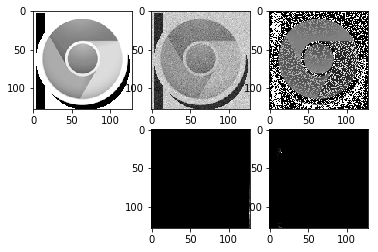

In [45]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
from scipy.misc import imread
import imagebase
import neighbour

def denoise(image):
    x = image.shape[0]
    y = image.shape[1]
    tempimage = image
    for t in range(1):
        for i in range(x):
            for j in range(y):
                w = 0
                for ne in neighbour.neighbours(i,j,x,y,4):
                    w += ((2*image[ne]-1)*(2*image[i,j]-1))
                
                tempimage[i,j] = (w*image[i,j]+1)/2
        image = tempimage
    return im

prop = 0.7
varSigma = 0.1

im = imageio.imread('chromegray.png')
im = im/255


fig = plt.figure()
ax = fig.add_subplot(231)
ax.imshow(im,cmap='gray')
imG = imagebase.add_gaussian_noise(im,prop,varSigma)
ax2 = fig.add_subplot(232)
ax2.imshow(imG,cmap='gray')
imS = imagebase.add_saltnpeppar_noise(im,prop)
ax3 = fig.add_subplot(233)
ax3.imshow(imS,cmap='gray')
print("pre denG")
denG = denoise(imG)
print("pre denS")
denS = denoise(imS)
ax4 = fig.add_subplot(235)
ax4.imshow(imG,cmap='gray')
ax5 = fig.add_subplot(236)
ax5.imshow(imS,cmap='gray')

In [37]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
from scipy.misc import imread
import imagebase
import neighbour
import math


def sigm(v):
    return (1 / (1 + np.exp(-v)))

#takes an image point value a 0..1
#takes a check value v -1..1
#returns Likelihood that a yields v
def p(a,v):
    res = 0
    val = (v + 1)/2
    if(a == val):
        res = 1
    else:
        res = 0
    return res

def l(image,i,j,x,y,v):
    res = 0
    sum = 0
    for ne in neighbour.neighbours(i,j,x,y,8):
        sum += p(image[ne],image[i][j])
    swap = sum/8
    if(image[i][j] == v):
        res = 1 - swap
    else:
        res = 0 + swap
    return res

def mfvb(image,iter):

    x = image.shape[0]
    y = image.shape[1]
    #Initialise the variational distributions
    #Initialise M
    m = np.zeros((x,y,iter+1),order='C')
    mu = np.zeros((x,y,iter+1),order='C')
    q = np.zeros((x,y),order='C')
    #image is latent

    for t in range(iter):
        #[ii][jj] pair comprises the singular i iterator used in CW specification
        for ii in range(x):
            for jj in range(y):
                sum = 0
                for ne in neighbour.neighbours(ii,jj,x,y,8):
                    #Add the -1..1 product value of neighbour with current, modified by the mu value for neighbour
                    sum += (2*image[ne] -1) * (2*image[ii][jj] -1) * mu[ne[0],ne[1],t]

                m[ii,jj,t+1] = 0
                mu[ii,jj,t+1] = math.tanh(m[ii,jj,t] + 1/2*(p(image[ii][jj],1) - p(image[ii][jj],-1)))

    qProb = 1
    for i in range(x):
        for j in range(y):
            q[i,j] = sigm(2*(m[ii,jj,iter] + 1/2*(p(image[ii][jj],1) - p(image[ii][jj],-1))))
            qProb *= q[i,j]

    #returns q(x == image)
    return qProb


prop = 0.7
varSigma = 0.1

im = imageio.imread('chromegray.png')
#im[i] = [0..1]
im = im/255

imG = imagebase.add_gaussian_noise(im,prop,varSigma)
imS = imagebase.add_saltnpeppar_noise(im,prop)
posterior = 0
posterior = mfvb(im,20)


In [29]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
from scipy.misc import imread
import imagebase
import neighbour
import math

im = imageio.imread('chromegray.png')
#im[i] = [0..1]
im = im/255

print(im[15][28])

print(math.tanh(2 + 0.43 - 0.68))

1.0
0.9413755384972874
